<a href="https://colab.research.google.com/github/parkyw2/parkyw2/blob/main/%EA%B8%B0%EC%9E%AC%ED%92%88_%EC%88%98%EC%84%A0%EB%B9%84_%EA%B3%B5%EC%9E%A5%EB%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%load_ext rpy2.ipython
%matplotlib inline
!pip install pystan~=2.14
!pip install fbprophet
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd drive/My\ Drive/회사 데이터

/content/drive/My Drive/회사 데이터


In [29]:
df = pd.read_csv('수선비_기재품_plant_20220308.csv')

In [30]:
df.tail(10)

,date,1110,1120,1130,1140,1150,1160,1170,1180,total
1086,2021-12-22,11015014,849749,0,4264120,12978,6244952,7855598,1986058,32228469
1087,2021-12-23,34990463,355232,0,7297627,0,5149153,5067257,6695754,59555486
1088,2021-12-24,5590498,6650433,0,1298763,0,2368324,3943195,0,19851213
1089,2021-12-25,1217584,0,0,219539,0,1212904,286747,0,2936774
1090,2021-12-26,50856,0,0,188500,0,0,106200,0,345556
1091,2021-12-27,8170353,5692078,0,4842059,0,5078067,892793,1207522,25882872
1092,2021-12-28,10194416,6245477,0,17376007,0,25430223,19868103,7006737,86120963
1093,2021-12-29,5964013,2509500,0,1770660,0,12632018,11809706,4455711,39141608
1094,2021-12-30,8877249,5982917,0,2974314,875123,18953435,13077730,10129300,60870068
1095,2021-12-31,8349826,1085740,0,8798434,0,14436548,7612966,0,40283514


In [31]:
df2 = df.loc[:, ['date', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180']]

In [32]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('수선비_기재품_20220321').sheet1

rows = worksheet.get_all_values()
print(rows)

df_new = pd.DataFrame.from_records(rows)
df_new = df_new[1:]
df_new.columns = ["date", "1110", "1120", "1130", "1140", "1150", "1160", "1170", "1180", "total"]
df_new = df_new.loc[:, ['date', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180']]
df_new = df_new.fillna(0)
df_new = df_new.astype({'1110':'int','1120':'int','1130':'int','1140':'int','1150':'int','1160':'int','1170':'int','1180':'int'})

[['date', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180', 'total'], ['2022-01-01', '0', '3283239', '0', '0', '0', '771166', '567660', '0', '4622065'], ['2022-01-02', '0', '0', '0', '0', '0', '199140', '0', '0', '199140'], ['2022-01-03', '2191422', '2413550', '0', '3048627', '0', '1333327', '430800', '9660', '9427386'], ['2022-01-04', '2027249', '2575771', '0', '1268000', '0', '4697450', '1807209', '43202', '12418881'], ['2022-01-05', '5694281', '6705740', '0', '3175188', '0', '17233921', '3416145', '891957', '37117232'], ['2022-01-06', '772272', '690580', '0', '2305195', '0', '2952847', '2296979', '158856', '9176729'], ['2022-01-07', '4995505', '530080', '0', '608999', '0', '6708387', '2663503', '371415', '15877889'], ['2022-01-08', '787193', '1172694', '0', '10400', '0', '256669', '1620', '0', '2228576'], ['2022-01-09', '4061888', '0', '0', '0', '0', '4624', '0', '0', '4066512'], ['2022-01-10', '7614602', '472555', '0', '3594835', '0', '1912836', '1534314', '0', '15129

In [33]:
df2 = pd.concat([df2,df_new], axis = 0)

In [34]:
df_date = df2['date']
df2 = df2[["1110", "1120", "1130", "1140", "1150", "1160", "1170", "1180"]]
df2[df2 < 0] = 0
df = pd.concat([df_date, df2], axis=1)
df.tail(3)

,date,1110,1120,1130,1140,1150,1160,1170,1180
231,2022-08-19,1876810,176475,0,8866877,0,3894160,7169212,6780196
232,2022-08-20,5287939,1333432,0,189600,0,6425185,1276305,0
233,2022-08-21,0,35087,0,0,0,0,0,0


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [35]:
from datetime import datetime

#안양
df_1110 = df[['date','1110']]
df_1110['ds'] = pd.to_datetime(df['date'])
df_1110['y'] = df_1110['1110']
df_1110 = df_1110.loc[:,['ds', 'y']]
df_1110['ds'] = pd.to_datetime(df_1110['ds'])
df_1110 = df_1110[df_1110['ds'].dt.dayofweek < 5]
df_1110['date_index'] = df_1110['ds']
df_1110 = df_1110.set_index('date_index')
df_1110['cap'] = 30000000
df_1110['floor'] = 0
df_1110 = df_1110[datetime(2019, 1, 1):datetime(2022, 8, 21)]

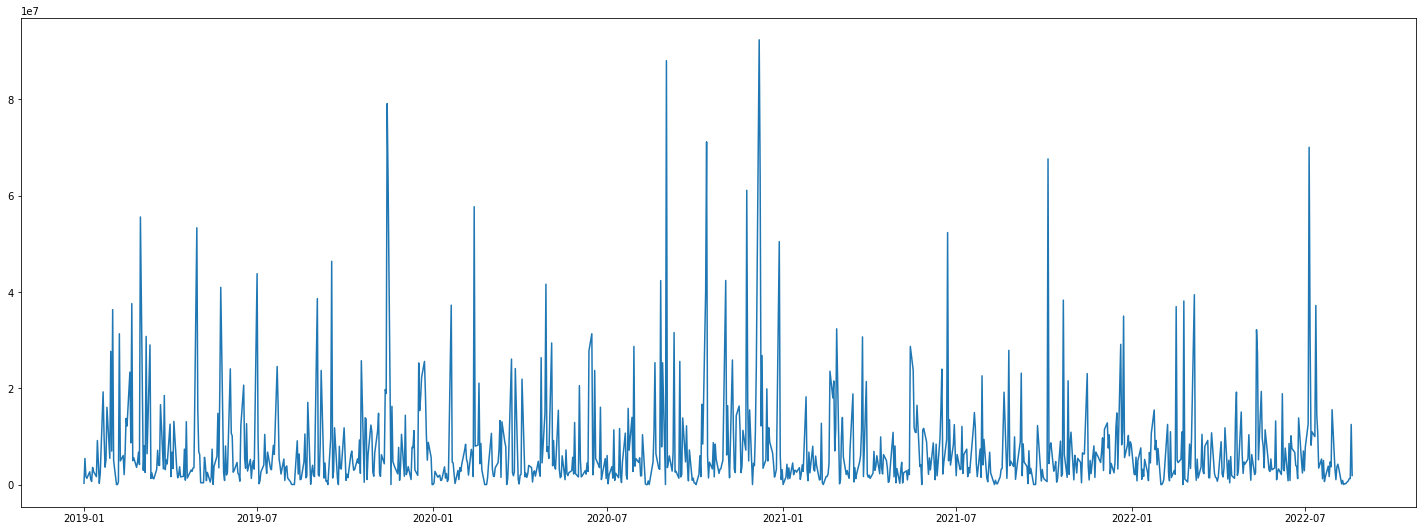

In [36]:
plt.figure(figsize = (25, 9))
plt.plot(df_1110.index,df_1110.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [37]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1110)

future = m.make_future_dataframe(periods=12)    # periods 수정!!
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 50000000
future['floor'] = 0

forecast=m.predict(future)
preds= forecast['yhat'][:-8]     # 숫자 수정!!

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


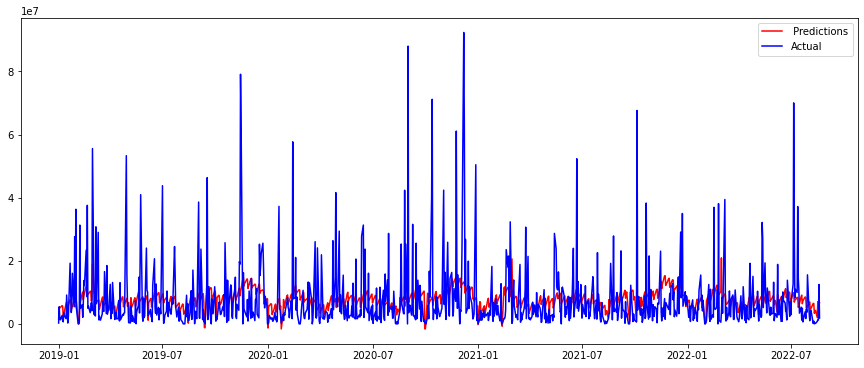

In [38]:
plt.figure(figsize=(15,6))
plt.plot(df_1110.index,preds,color='red',label=' Predictions')
plt.plot(df_1110.index,df_1110.y,color='blue',label='Actual')
plt.legend()
plt.show()

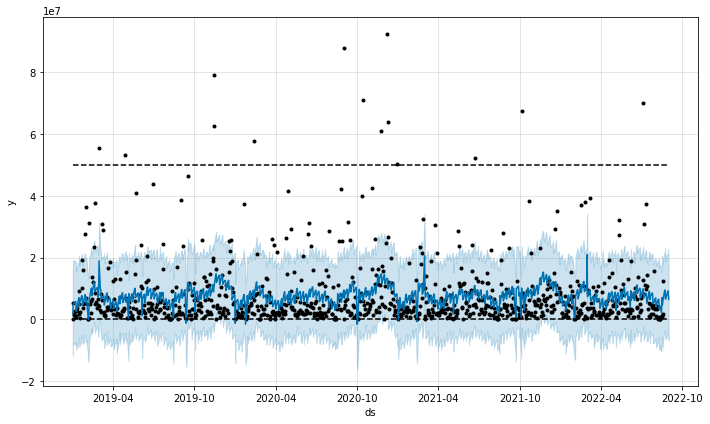

In [39]:
fig = m.plot(m.predict(future))

In [40]:
r2 = round(r2_score(df_1110["y"], preds), 3)
mse = round(mean_squared_error(df_1110["y"], preds), 3)
mae = round(mean_absolute_error(df_1110["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.066
MSE:  104927312448209.9
MAE:  6131389.696


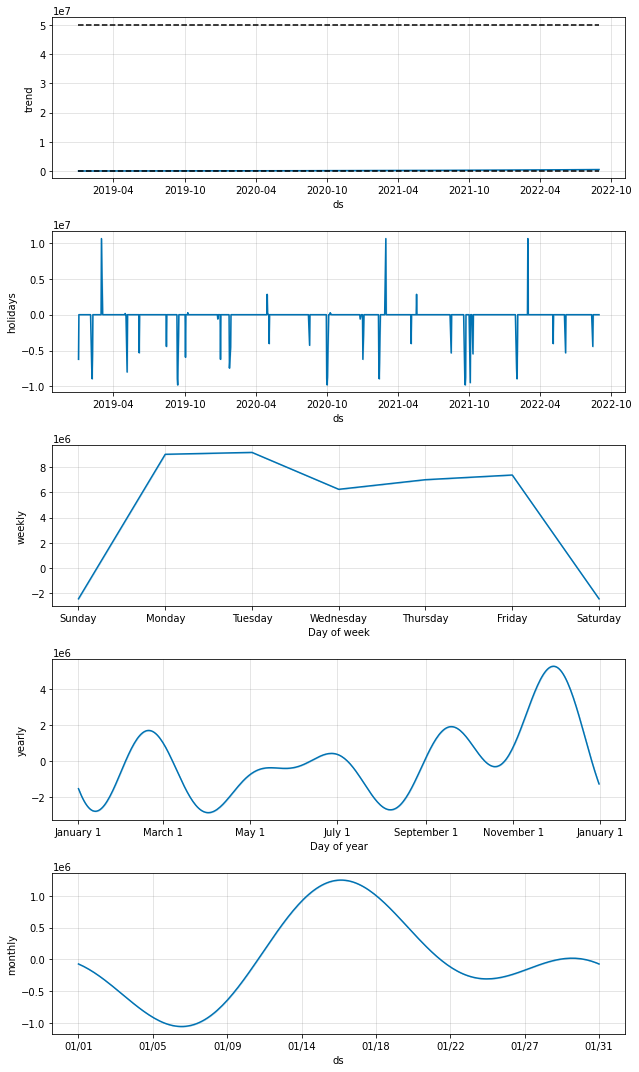

In [41]:
fig = m.plot_components(forecast)

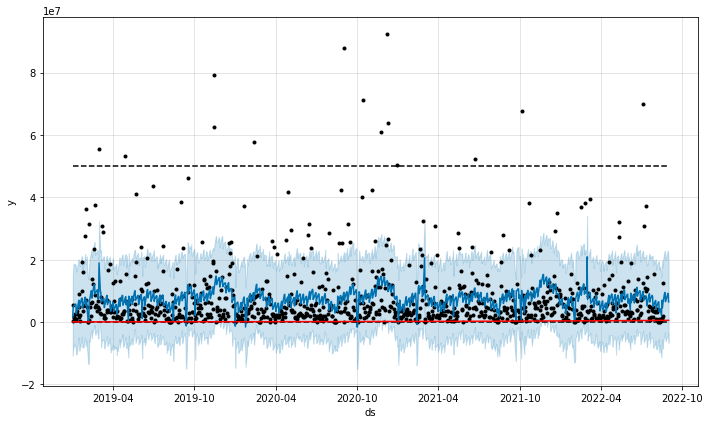

In [42]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [43]:
  pd.options.display.float_format = '{:,.0f}'.format

In [44]:
final_1110 = forecast[['ds', 'yhat']]
final_1110['yhat_1110'] = final_1110['yhat']
final_1110 = final_1110[['ds', 'yhat_1110']]
final_1110.tail()

,ds,yhat_1110
952,2022-08-25,"7,221,045"
953,2022-08-26,"7,469,978"
954,2022-08-29,"8,952,403"
955,2022-08-30,"9,199,294"
956,2022-08-31,"6,458,864"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [45]:
#Ansung

df_1120 = df[['date','1120']]
df_1120['ds'] = pd.to_datetime(df_1120['date'])
df_1120['y'] = df_1120['1120']
df_1120 = df_1120.loc[:,['ds', 'y']]
df_1120['ds'] = pd.to_datetime(df_1120['ds'])
df_1120 = df_1120[df_1120['ds'].dt.dayofweek < 5]
df_1120['date_index'] = df_1120['ds']
df_1120 = df_1120.set_index('date_index')
df_1120['cap'] = 30000000
df_1120['floor'] = 0
df_1120 = df_1120[datetime(2019, 1, 1):datetime(2022, 8, 21)]

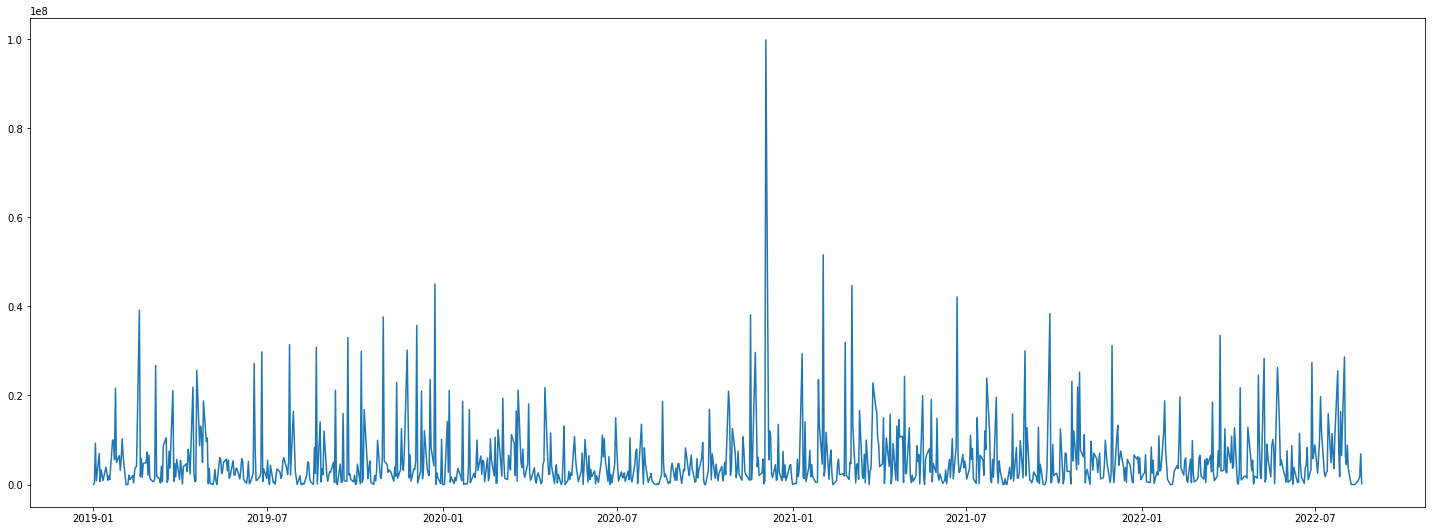

In [46]:
plt.figure(figsize = (25, 9))
plt.plot(df_1120.index,df_1120.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [47]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1120)

future = m.make_future_dataframe(periods=12)             # periods를 수정!!
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 35000000
future['floor'] = 0
forecast=m.predict(future)
preds= forecast['yhat'][:-8]                  # 숫자를 수정!!

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


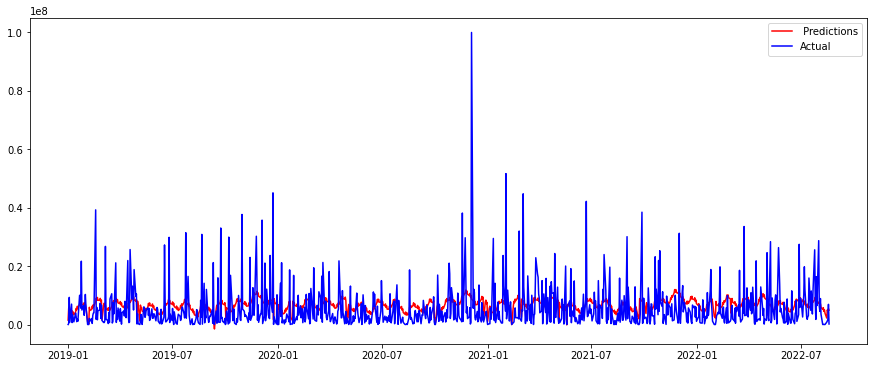

In [48]:
plt.figure(figsize=(15,6))
plt.plot(df_1120.index,preds,color='red',label=' Predictions')
plt.plot(df_1120.index,df_1120.y,color='blue',label='Actual')
plt.legend()
plt.show()

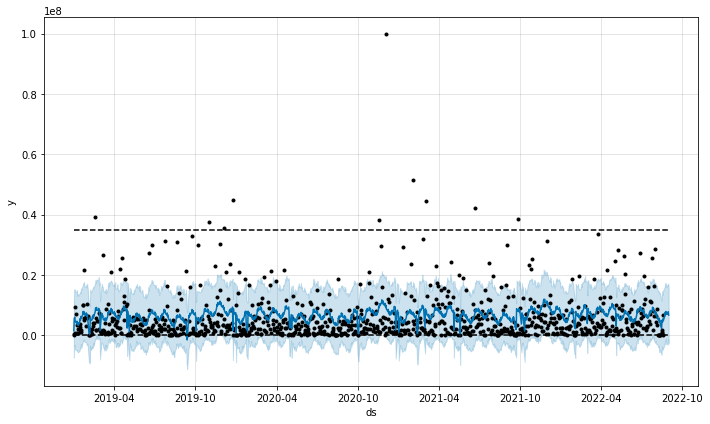

In [49]:
fig = m.plot(m.predict(future))

In [50]:
r2 = round(r2_score(df_1120["y"], preds), 3)
mse = round(mean_squared_error(df_1120["y"], preds), 3)
mae = round(mean_absolute_error(df_1120["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.038
MSE:  56219205957775.14
MAE:  5133476.41


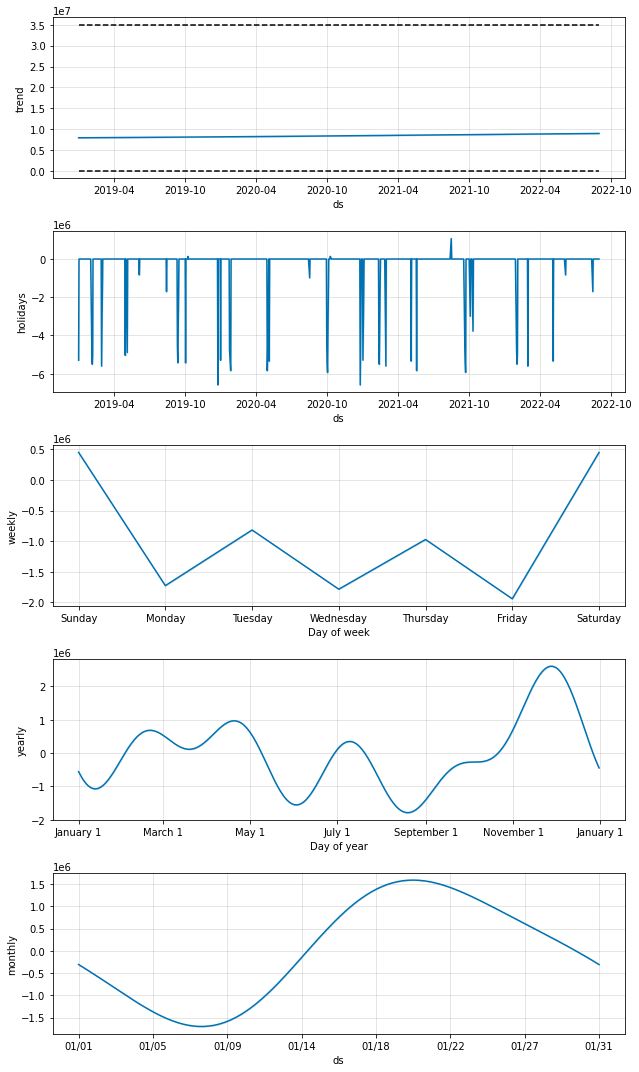

In [51]:
fig = m.plot_components(forecast)

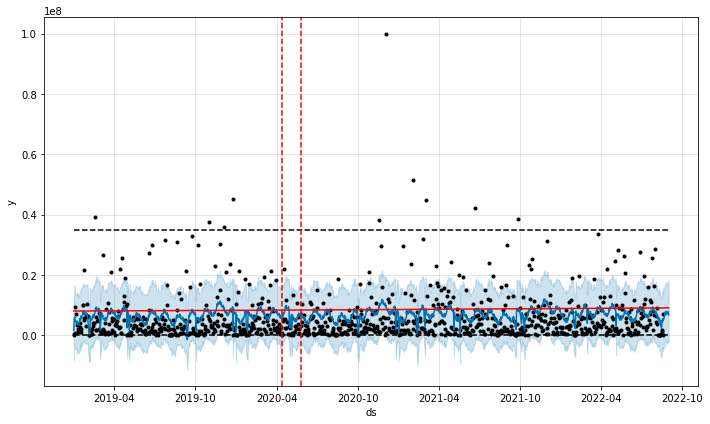

In [52]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [53]:
final_1120 = forecast[['ds', 'yhat']]
final_1120['yhat_1120'] = final_1120['yhat']
final_1120 = final_1120[['ds', 'yhat_1120']]
final_1120.tail()

,ds,yhat_1120
952,2022-08-25,"7,863,449"
953,2022-08-26,"6,978,012"
954,2022-08-29,"7,037,878"
955,2022-08-30,"7,815,909"
956,2022-08-31,"6,704,157"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [54]:
#Asan

df_1140 = df[['date','1140']]
df_1140['ds'] = pd.to_datetime(df_1140['date'])
df_1140['y'] = df_1140['1140']
df_1140 = df_1140.loc[:,['ds', 'y']]

df_1140['ds'] = pd.to_datetime(df_1140['ds'])
df_1140 = df_1140[df_1140['ds'].dt.dayofweek < 5]
df_1140['date_index'] = df_1140['ds']
df_1140 = df_1140.set_index('date_index')
df_1140['cap'] = 30000000
df_1140['floor'] = 0

df_1140 = df_1140[datetime(2019, 1, 1):datetime(2022, 8, 21)]

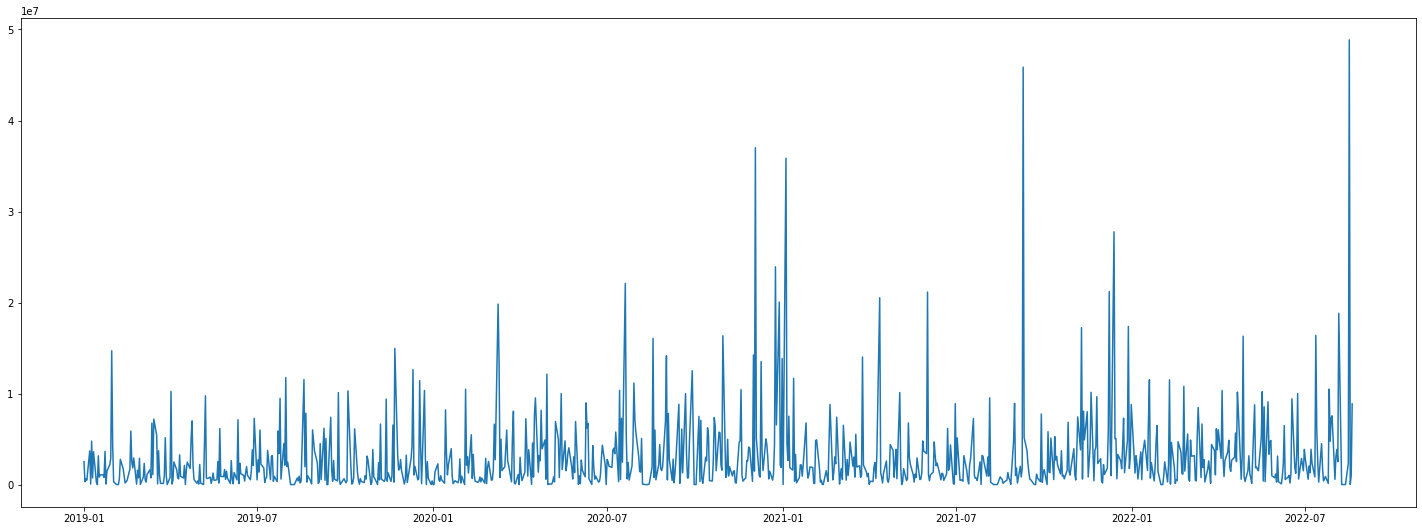

In [55]:
plt.figure(figsize = (25, 9))
plt.plot(df_1140.index,df_1140.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [56]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1140)

future = m.make_future_dataframe(periods=12)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-8]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


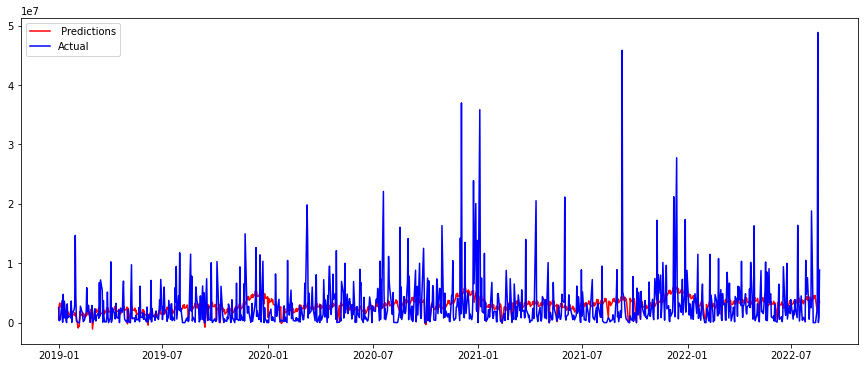

In [57]:
plt.figure(figsize=(15,6))
plt.plot(df_1140.index,preds,color='red',label=' Predictions')
plt.plot(df_1140.index,df_1140.y,color='blue',label='Actual')
plt.legend()
plt.show()

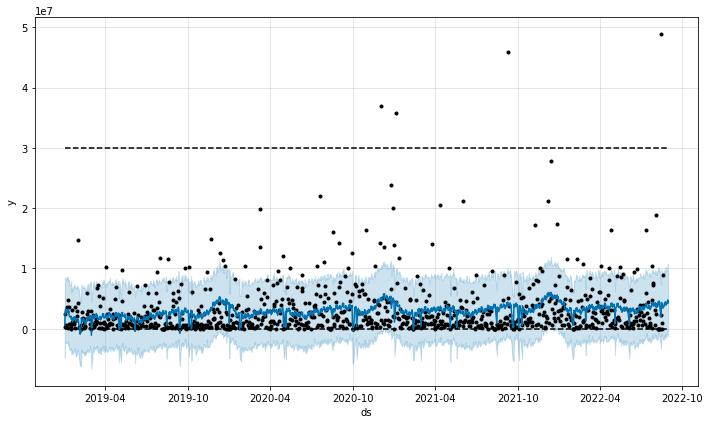

In [58]:
fig = m.plot(m.predict(future))

In [59]:
r2 = round(r2_score(df_1140["y"], preds), 3)
mse = round(mean_squared_error(df_1140["y"], preds), 3)
mae = round(mean_absolute_error(df_1140["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.064
MSE:  17896407634592.363
MAE:  2554695.614


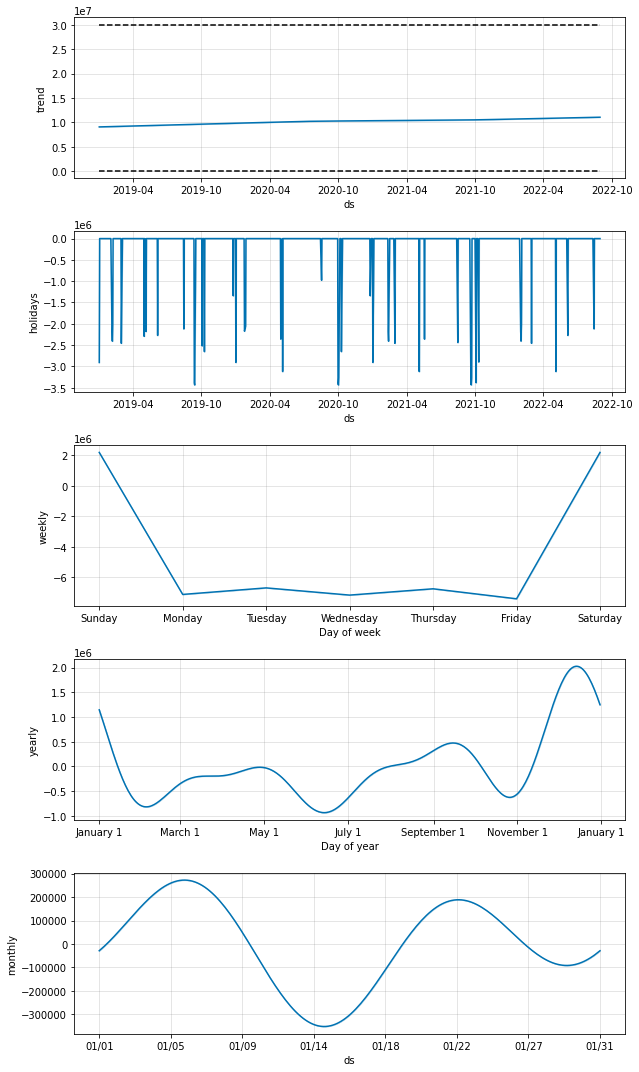

In [60]:
fig = m.plot_components(forecast)

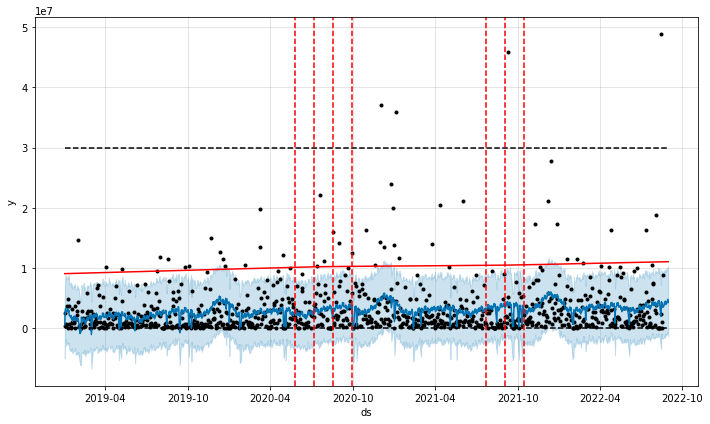

In [61]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [62]:
final_1140 = forecast[['ds', 'yhat']]
final_1140['yhat_1140'] = final_1140['yhat']
final_1140 = final_1140[['ds', 'yhat_1140']]
final_1140.tail()

,ds,yhat_1140
952,2022-08-25,"4,492,949"
953,2022-08-26,"3,944,326"
954,2022-08-29,"4,376,852"
955,2022-08-30,"4,789,187"
956,2022-08-31,"4,278,909"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [63]:
#Poseung

df_1150 = df[['date','1150']]
df_1150['ds'] = pd.to_datetime(df_1150['date'])
df_1150['y'] = df_1150['1150']
df_1150 = df_1150.loc[:,['ds', 'y']]

df_1150['ds'] = pd.to_datetime(df_1150['ds'])
df_1150 = df_1150[df_1150['ds'].dt.dayofweek < 5]
df_1150['date_index'] = df_1150['ds']
df_1150 = df_1150.set_index('date_index')
df_1150['cap'] = 30000000
df_1150['floor'] = 0

df_1150 = df_1150[datetime(2019, 1, 1):datetime(2022, 8, 21)]

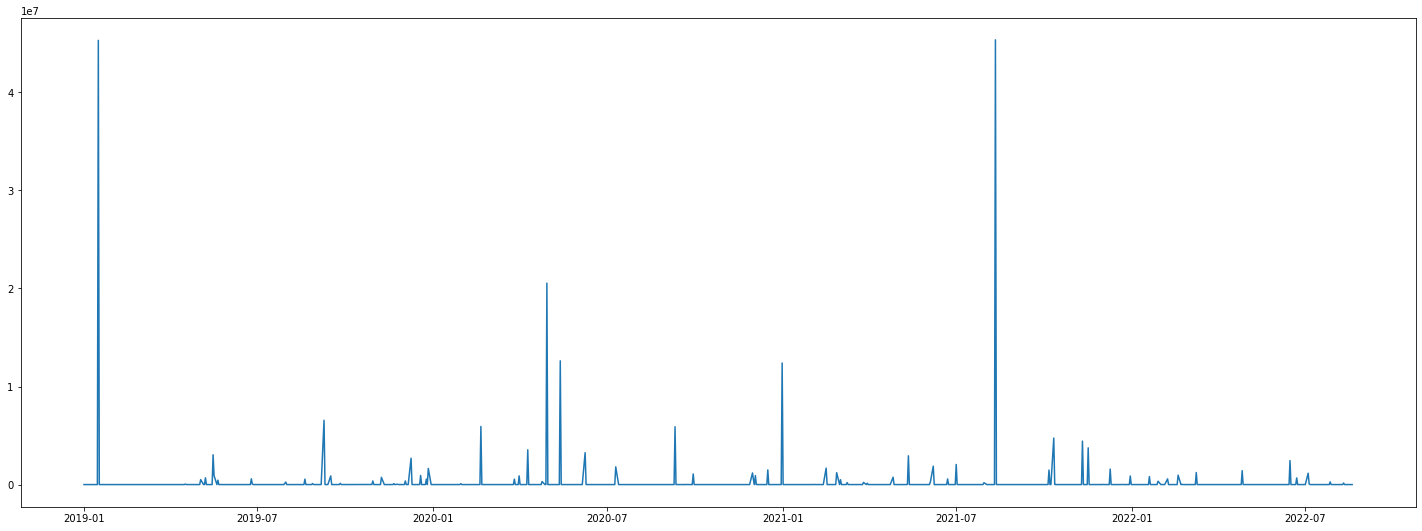

In [64]:
plt.figure(figsize = (25, 9))
plt.plot(df_1150.index,df_1150.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)



In [65]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1150)

future = m.make_future_dataframe(periods=12)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 25000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-8]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


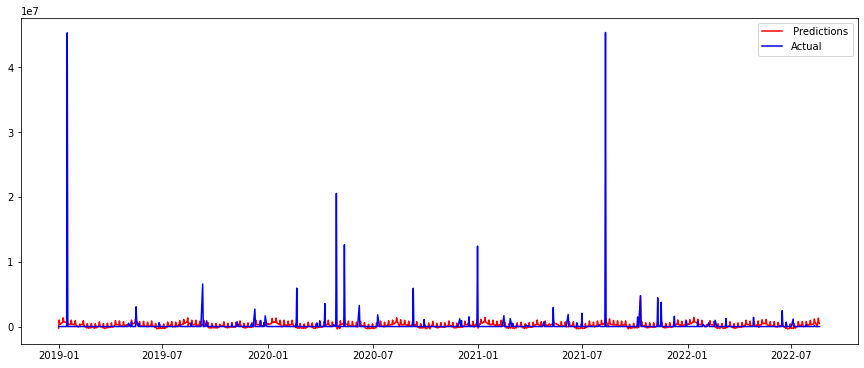

In [66]:
plt.figure(figsize=(15,6))
plt.plot(df_1150.index,preds,color='red',label=' Predictions')
plt.plot(df_1150.index,df_1150.y,color='blue',label='Actual')
plt.legend()
plt.show()

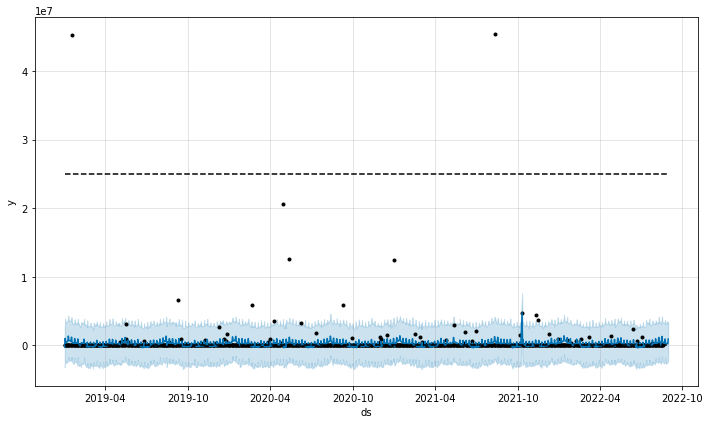

In [67]:
fig = m.plot(m.predict(future))

In [68]:
r2 = round(r2_score(df_1150["y"], preds), 3)
mse = round(mean_squared_error(df_1150["y"], preds), 3)
mae = round(mean_absolute_error(df_1150["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.028
MSE:  5182839010344.591
MAE:  514159.61


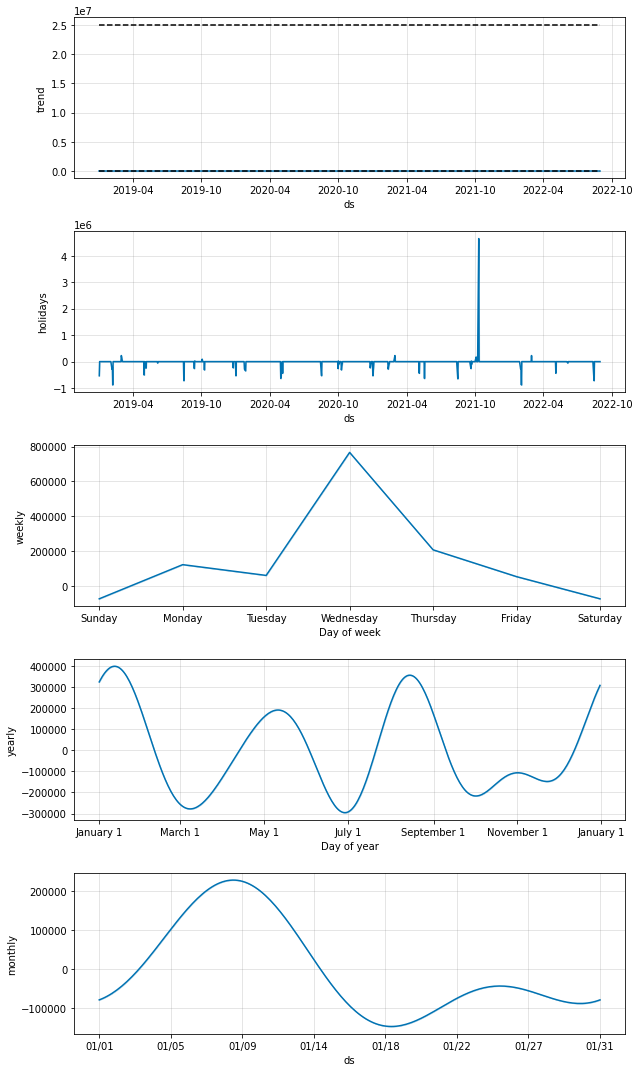

In [69]:
fig = m.plot_components(forecast)

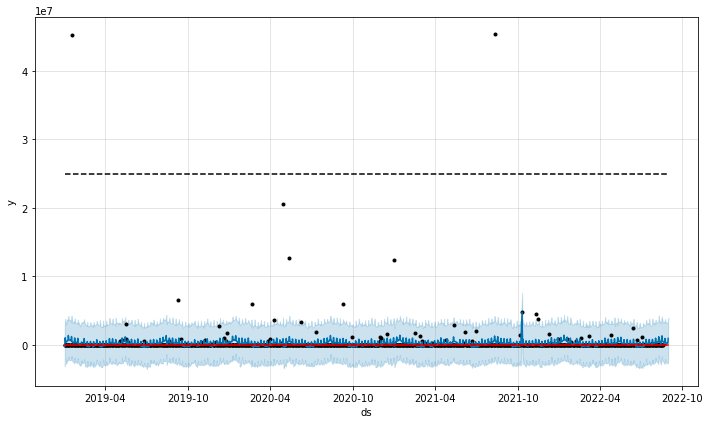

In [70]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [71]:
final_1150 = forecast[['ds', 'yhat']]
final_1150['yhat_1150'] = final_1150['yhat']
final_1150 = final_1150[['ds', 'yhat_1150']]
final_1150.tail()

,ds,yhat_1150
952,2022-08-25,"351,935"
953,2022-08-26,"199,377"
954,2022-08-29,"289,682"
955,2022-08-30,"224,121"
956,2022-08-31,"917,655"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [72]:
#GUMI
df_1160 = df[['date','1160']]
df_1160['ds'] = pd.to_datetime(df_1160['date'])
df_1160['y'] = df_1160['1160']
df_1160 = df_1160.loc[:,['ds', 'y']]

df_1160['ds'] = pd.to_datetime(df_1160['ds'])
df_1160 = df_1160[df_1160['ds'].dt.dayofweek < 5]
df_1160['date_index'] = df_1160['ds']
df_1160 = df_1160.set_index('date_index')
df_1160['cap'] = 30000000
df_1160['floor'] = 0

df_1160 = df_1160[datetime(2019, 1, 1):datetime(2022, 8, 21)]

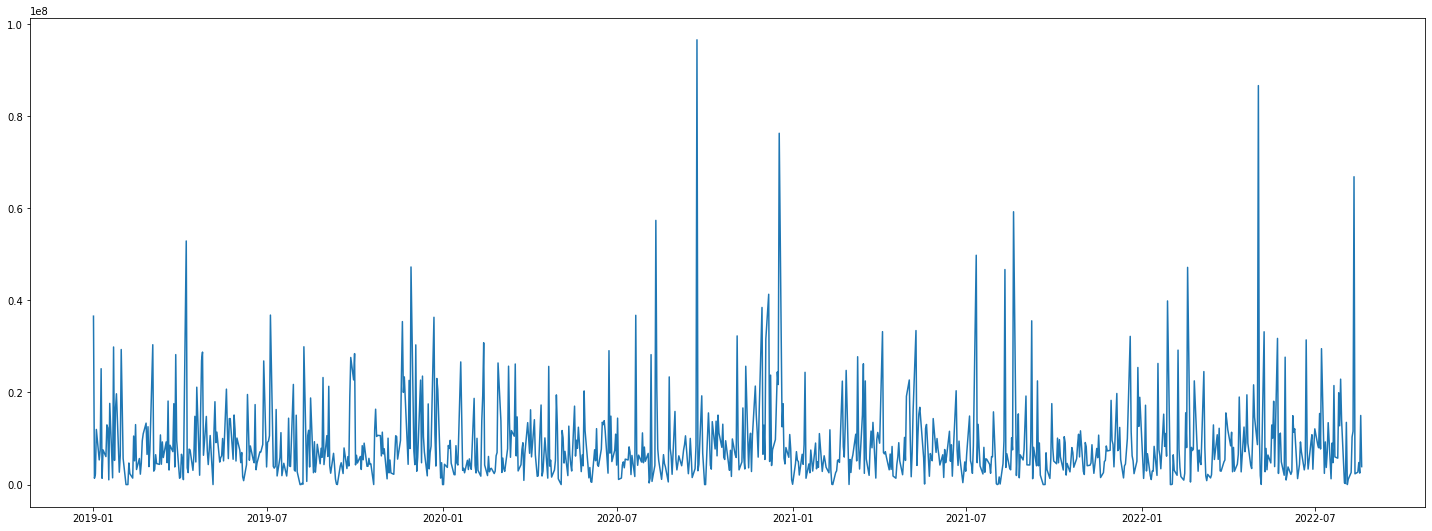

In [73]:
plt.figure(figsize = (25, 9))
plt.plot(df_1160.index,df_1160.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [74]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1160)

future = m.make_future_dataframe(periods=12)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-8]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


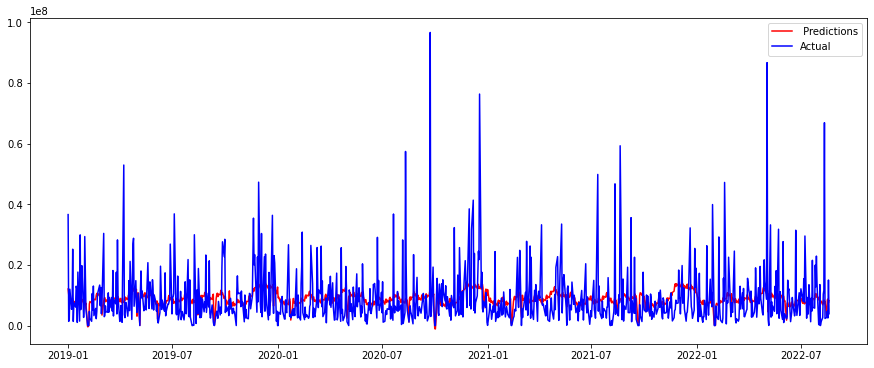

In [75]:
plt.figure(figsize=(15,6))
plt.plot(df_1160.index,preds,color='red',label=' Predictions')
plt.plot(df_1160.index,df_1160.y,color='blue',label='Actual')
plt.legend()
plt.show()

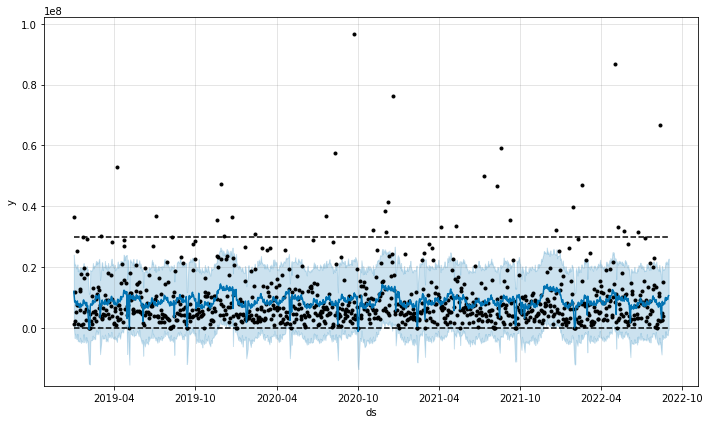

In [76]:
fig = m.plot(m.predict(future))

In [77]:
r2 = round(r2_score(df_1160["y"], preds), 3)
mse = round(mean_squared_error(df_1160["y"], preds), 3)
mae = round(mean_absolute_error(df_1160["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.055
MSE:  83637959014990.39
MAE:  5786647.386


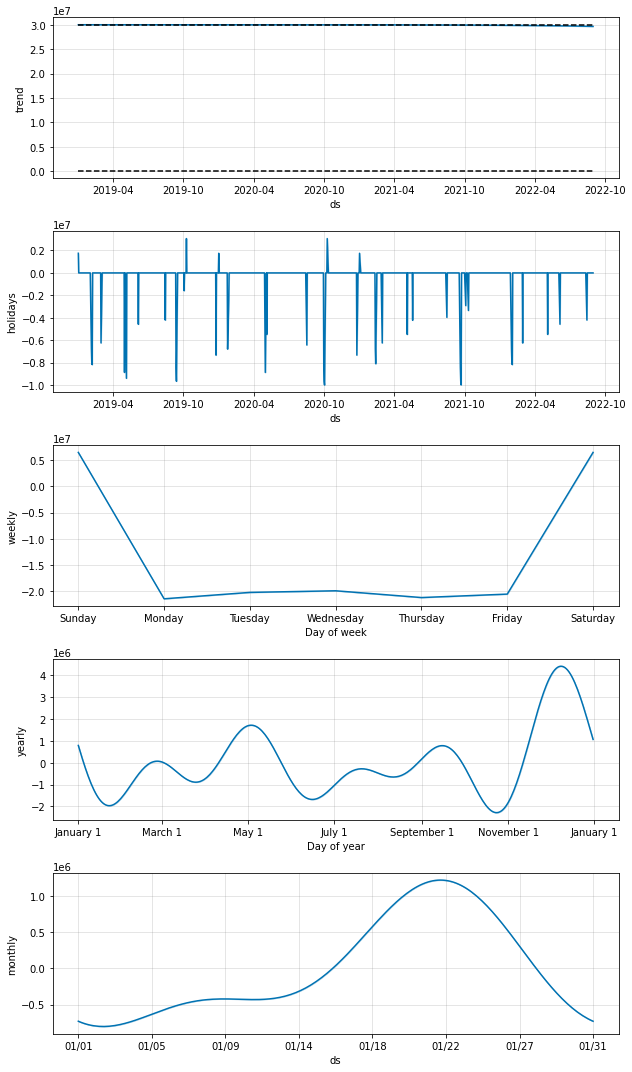

In [78]:
fig = m.plot_components(forecast)

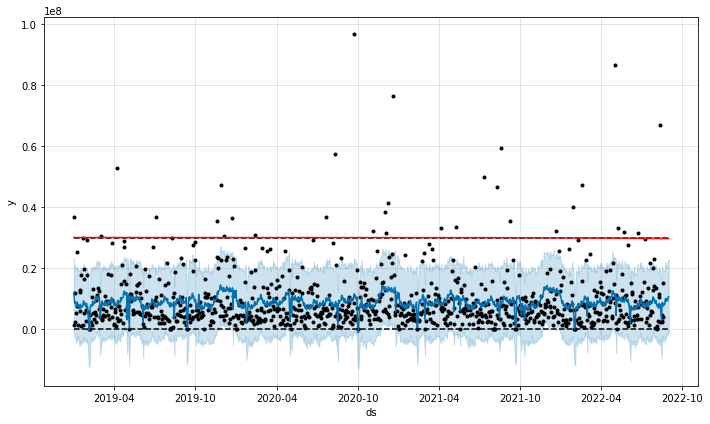

In [79]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [80]:
final_1160 = forecast[['ds', 'yhat']]
final_1160['yhat_1160'] = final_1160['yhat']
final_1160 = final_1160[['ds', 'yhat_1160']]
final_1160.tail()

,ds,yhat_1160
952,2022-08-25,"9,038,951"
953,2022-08-26,"9,951,675"
954,2022-08-29,"9,363,224"
955,2022-08-30,"10,497,744"
956,2022-08-31,"10,642,239"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [81]:
#Pusan
df_1170 = df[['date','1170']]
df_1170['ds'] = pd.to_datetime(df_1170['date'])
df_1170['y'] = df_1170['1170']
df_1170 = df_1170.loc[:,['ds', 'y']]

df_1170['ds'] = pd.to_datetime(df_1170['ds'])
df_1170 = df_1170[df_1170['ds'].dt.dayofweek < 5]
df_1170['date_index'] = df_1170['ds']
df_1170 = df_1170.set_index('date_index')
df_1170['cap'] = 30000000
df_1170['floor'] = 0

df_1170 = df_1170[datetime(2019, 1, 1):datetime(2022, 8, 21)]

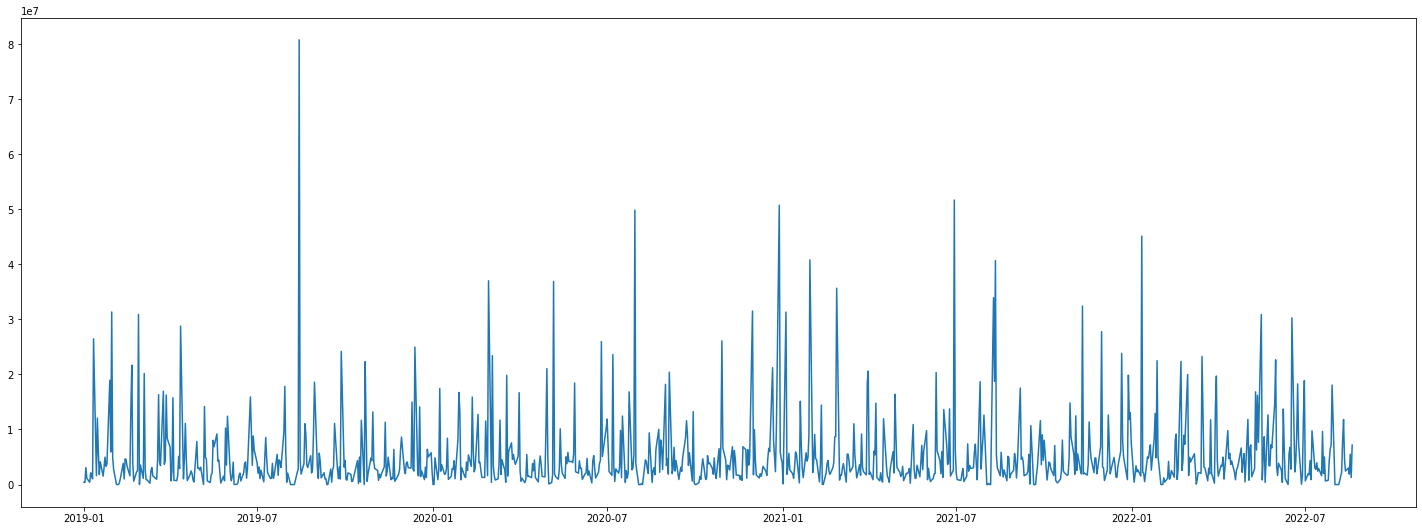

In [82]:
plt.figure(figsize = (25, 9))
plt.plot(df_1170.index,df_1170.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [83]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1170)

future = m.make_future_dataframe(periods=12)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 50000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-8]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


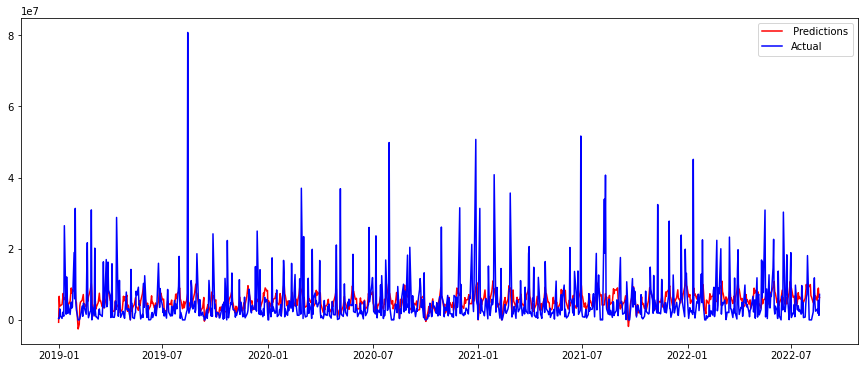

In [84]:
plt.figure(figsize=(15,6))
plt.plot(df_1170.index,preds,color='red',label=' Predictions')
plt.plot(df_1170.index,df_1170.y,color='blue',label='Actual')
plt.legend()
plt.show()

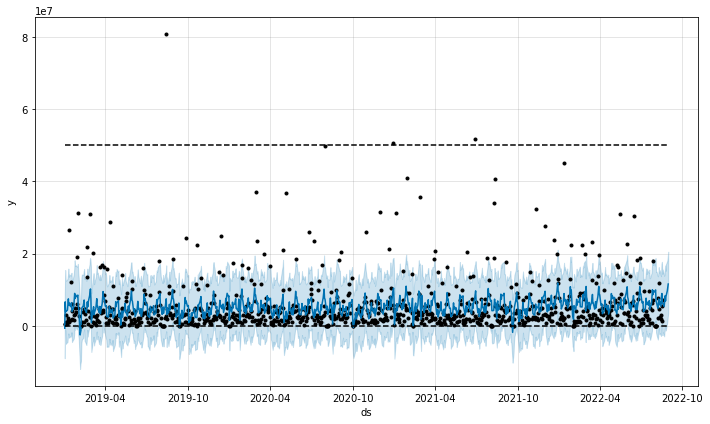

In [85]:
fig = m.plot(m.predict(future))

In [86]:
r2 = round(r2_score(df_1170["y"], preds), 3)
mse = round(mean_squared_error(df_1170["y"], preds), 3)
mae = round(mean_absolute_error(df_1170["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.083
MSE:  45785961976865.516
MAE:  4110555.603


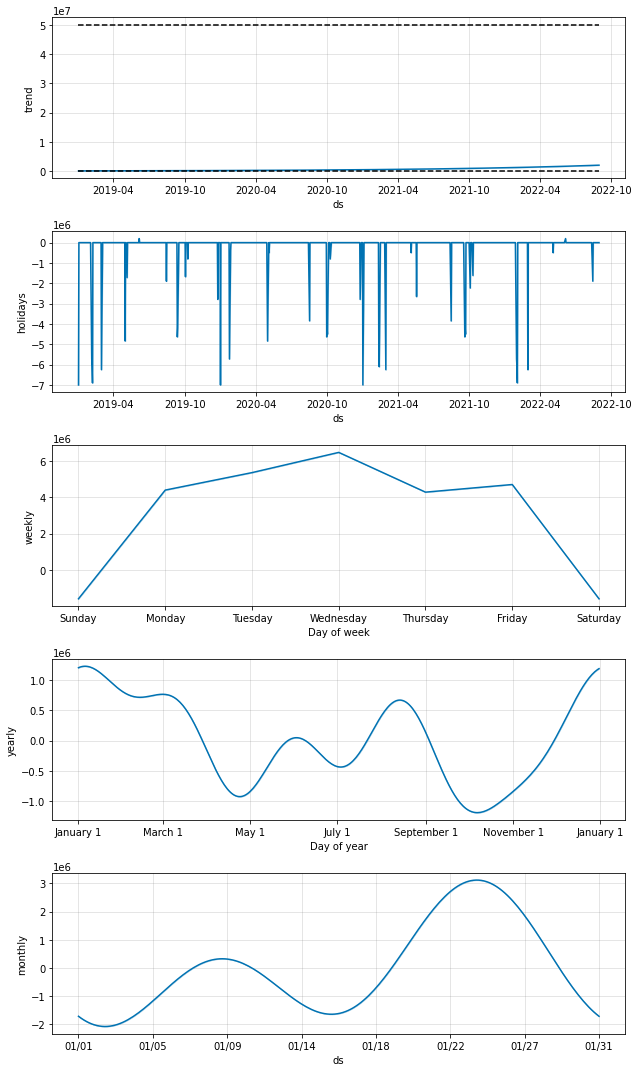

In [87]:
fig = m.plot_components(forecast)

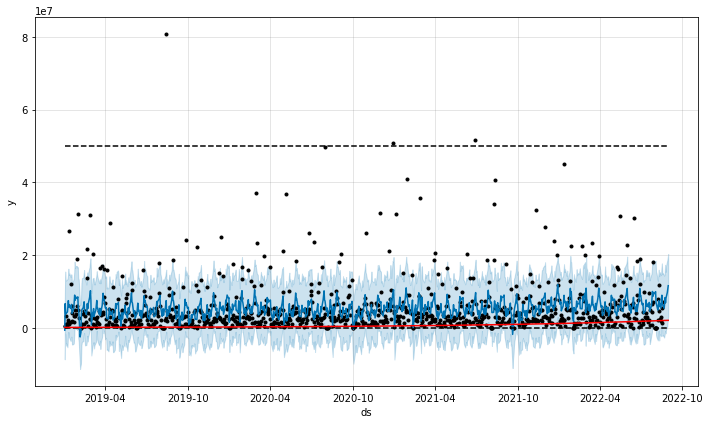

In [88]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [89]:
final_1170 = forecast[['ds', 'yhat']]
final_1170['yhat_1170'] = final_1170['yhat']
final_1170 = final_1170[['ds', 'yhat_1170']]
final_1170.tail()

,ds,yhat_1170
952,2022-08-25,"6,859,763"
953,2022-08-26,"8,122,710"
954,2022-08-29,"9,692,009"
955,2022-08-30,"10,725,807"
956,2022-08-31,"11,561,371"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [90]:
#Noksan

df_1180 = df[['date','1180']]
df_1180['ds'] = pd.to_datetime(df_1180['date'])
df_1180['y'] = df_1180['1180']
df_1180 = df_1180.loc[:,['ds', 'y']]

df_1180['ds'] = pd.to_datetime(df_1180['ds'])
df_1180 = df_1180[df_1180['ds'].dt.dayofweek < 5]
df_1180['date_index'] = df_1180['ds']
df_1180 = df_1180.set_index('date_index')
df_1180['cap'] = 30000000
df_1180['floor'] = 0

df_1180 = df_1180[datetime(2019, 1, 1):datetime(2022, 8, 21)]

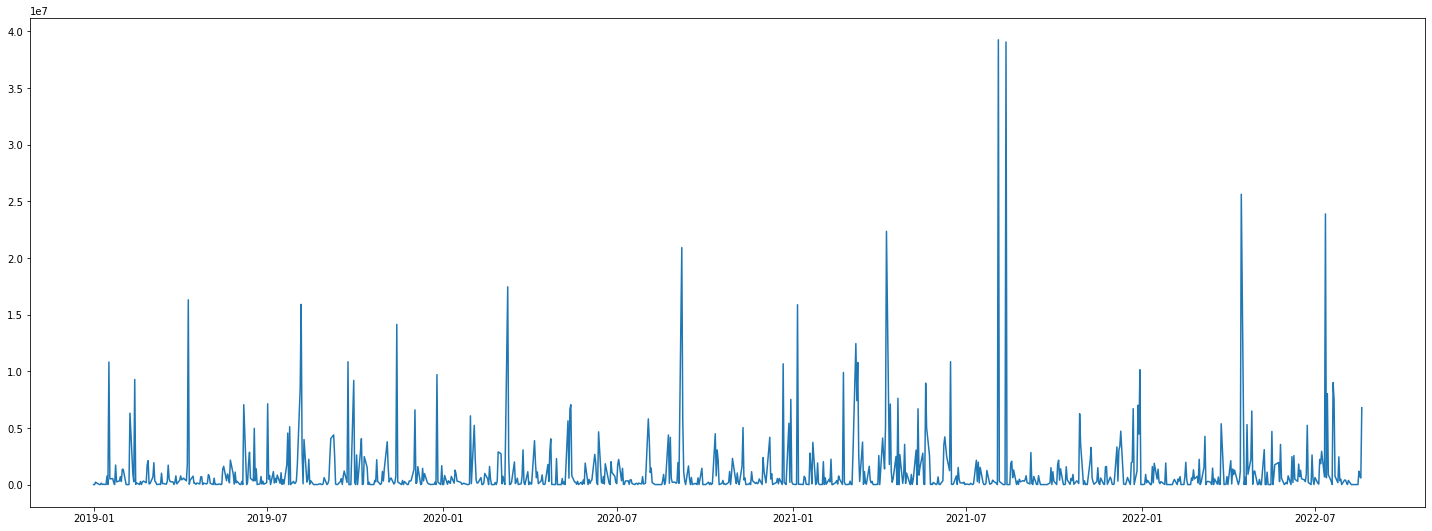

In [91]:
plt.figure(figsize = (25, 9))
plt.plot(df_1180.index,df_1180.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [92]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1180)

future = m.make_future_dataframe(periods=12)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-8]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


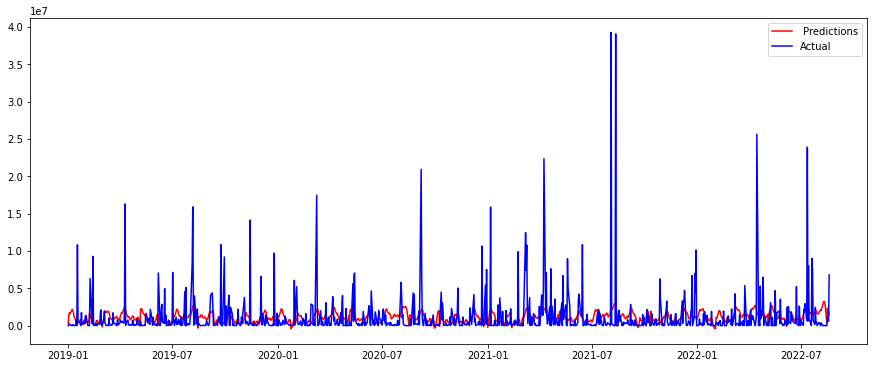

In [93]:
plt.figure(figsize=(15,6))
plt.plot(df_1180.index,preds,color='red',label=' Predictions')
plt.plot(df_1180.index,df_1180.y,color='blue',label='Actual')
plt.legend()
plt.show()

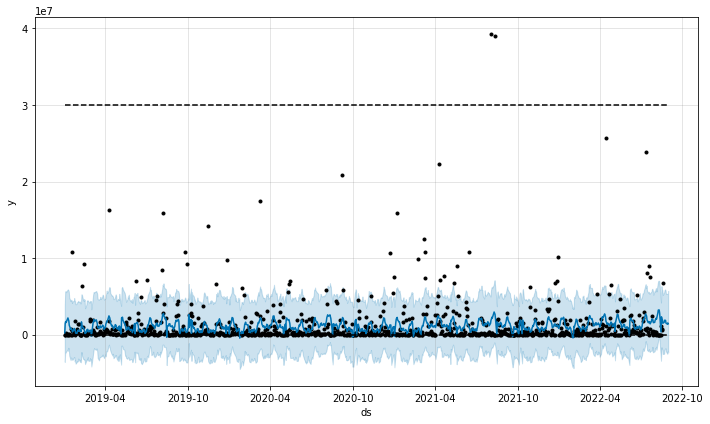

In [94]:
fig = m.plot(m.predict(future))

In [95]:
r2 = round(r2_score(df_1180["y"], preds), 3)
mse = round(mean_squared_error(df_1180["y"], preds), 3)
mae = round(mean_absolute_error(df_1180["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.043
MSE:  9070079519020.873
MAE:  1448376.162


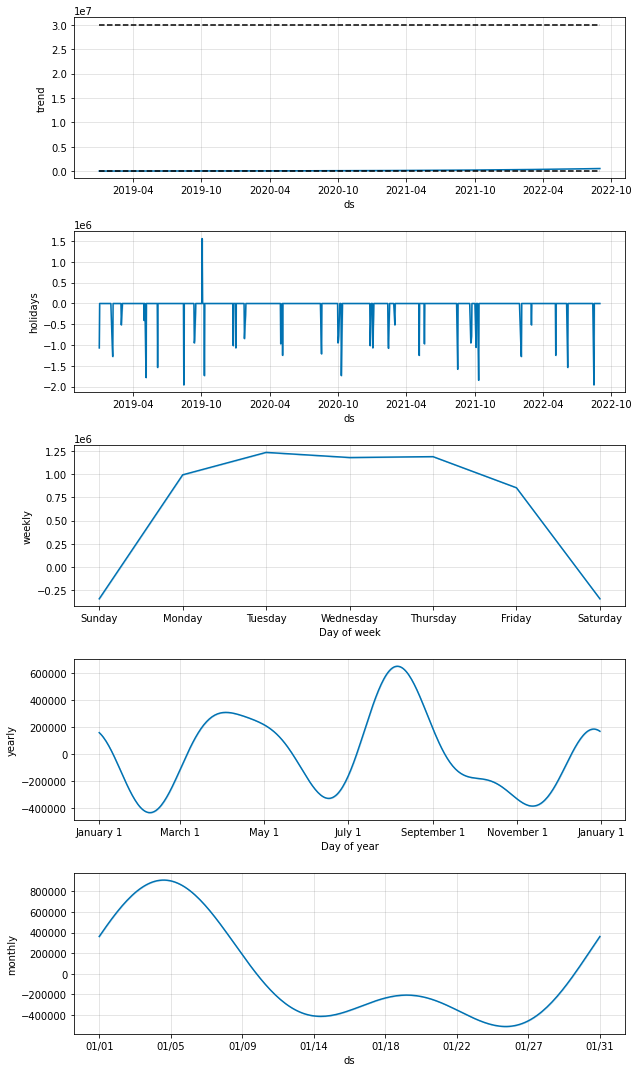

In [96]:
fig = m.plot_components(forecast)

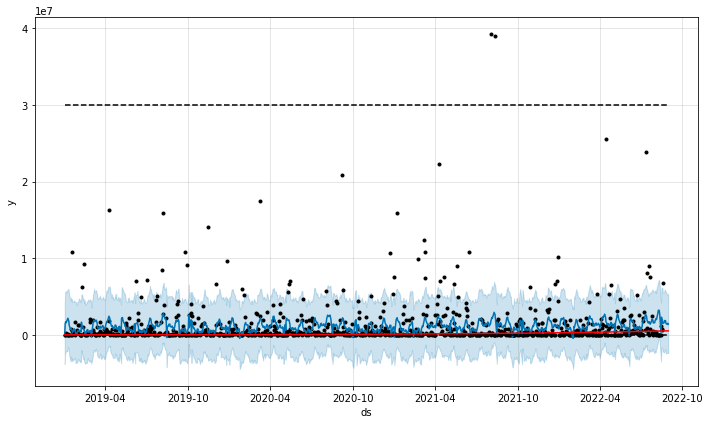

In [97]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [98]:
final_1180 = forecast[['ds', 'yhat']]
final_1180['yhat_1180'] = final_1180['yhat']
final_1180 = final_1180[['ds', 'yhat_1180']]
final_1180.tail()

,ds,yhat_1180
952,2022-08-25,"1,872,195"
953,2022-08-26,"1,504,046"
954,2022-08-29,"1,381,152"
955,2022-08-30,"1,531,363"
956,2022-08-31,"1,417,080"


In [99]:
final_1110['date_index'] = final_1110['ds']
final_1110 = final_1110.set_index('date_index')

final_1120['date_index'] = final_1120['ds']
final_1120 = final_1120.set_index('date_index')

final_1140['date_index'] = final_1140['ds']
final_1140 = final_1140.set_index('date_index')

final_1150['date_index'] = final_1150['ds']
final_1150 = final_1150.set_index('date_index')

final_1160['date_index'] = final_1160['ds']
final_1160 = final_1160.set_index('date_index')

final_1170['date_index'] = final_1170['ds']
final_1170 = final_1170.set_index('date_index')

final_1180['date_index'] = final_1180['ds']
final_1180 = final_1180.set_index('date_index')

In [100]:
#음수는 0으로 처리. 오류가 나서 생략
#final_1110['yhat_1110'] < 0 = 0
#final_1120['yhat_1120'] < 0 = 0
#final_1140['yhat_1140'] < 0 = 0
#final_1150['yhat_1150'] < 0 = 0
#final_1160['yhat_1160'] < 0 = 0
#final_1170['yhat_1170'] < 0 = 0
#final_1180['yhat_1180'] < 0 = 0

In [101]:
final_1110 = final_1110[730:]
final_1120 = final_1120[730:]
final_1140 = final_1140[730:]
final_1150 = final_1150[730:]
final_1160 = final_1160[730:]
final_1170 = final_1170[730:]
final_1180 = final_1180[730:]

In [102]:
final_total = pd.merge(final_1110, final_1120)
final_total = pd.merge(final_total, final_1140)
final_total = pd.merge(final_total, final_1150)
final_total = pd.merge(final_total, final_1160)
final_total = pd.merge(final_total, final_1170)
final_total = pd.merge(final_total, final_1180)

In [103]:
final_total['final_sum'] = final_total['yhat_1110'] + final_total['yhat_1120'] + final_total['yhat_1140'] + final_total['yhat_1150'] + final_total['yhat_1160'] +final_total['yhat_1170'] + final_total['yhat_1180']


✅final_total.tail(8) 에서 8 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [104]:
final_total.tail(8)

,ds,yhat_1110,yhat_1120,yhat_1140,yhat_1150,yhat_1160,yhat_1170,yhat_1180,final_sum
219,2022-08-22,"9,263,555","6,346,499","3,788,887","340,738","7,907,104","5,351,982","1,611,533","34,610,299"
220,2022-08-23,"9,491,016","7,591,095","4,315,954","238,724","9,414,697","6,615,396","1,890,105","39,556,987"
221,2022-08-24,"6,551,929","6,880,844","3,960,283","921,609","10,030,273","8,285,813","1,861,773","38,492,524"
222,2022-08-25,"7,221,045","7,863,449","4,492,949","351,935","9,038,951","6,859,763","1,872,195","37,700,288"
223,2022-08-26,"7,469,978","6,978,012","3,944,326","199,377","9,951,675","8,122,710","1,504,046","38,170,125"
224,2022-08-29,"8,952,403","7,037,878","4,376,852","289,682","9,363,224","9,692,009","1,381,152","41,093,200"
225,2022-08-30,"9,199,294","7,815,909","4,789,187","224,121","10,497,744","10,725,807","1,531,363","44,783,425"
226,2022-08-31,"6,458,864","6,704,157","4,278,909","917,655","10,642,239","11,561,371","1,417,080","41,980,275"
